# Ontoforce Query Analysis

## 1. Query feature extraction

In [1]:
import os  
import subprocess
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
skip_feature_extraction = True
import numpy as np

In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

In [3]:
#helper functions for serialization and figure exports
def serializeDFtoTSVWithIndex(sim_ids, dfs, description_prefix):
    for sim,df in zip(sim_ids, dfs):
            filename = description_prefix + "_" + sim + ".tsv"
            df.to_csv(filename, sep="\t",  index=True)
            
#DEMO fig export:
#fig, ax = plt.subplots(1, 1, figsize=(20,10))
#fig.savefig('QuerySurvival_VirtuosoN3_64.svg', format='svg', bbox_inches='tight', dpi=1200)
#fig.savefig('QuerySurvival_VirtuosoN3_64.eps', format='eps', bbox_inches='tight', dpi=1200)

In [4]:
query_dir = './OntoforceQueries/templated/queries/'
json_dir = './OntoforceQueries_JSON/'

query_files = []

for fn in os.listdir(query_dir):
    query_files.append(fn)

print(len(query_files))        

1223


In [5]:
def convertSparqlToJson(input_path,sparql_file,output_path):
    output_file = output_path + sparql_file + ".json"

    with open(output_file, 'w+') as out:

        test = subprocess.Popen(["./sparql-to-json", input_path+sparql_file], stdout=out)

def extractFeaturesOfQuery(input_path, json_file, output_path):
    output_file = output_path + json_file.split('.')[0] +  "_analyzed.json"
    
    with open(output_file, 'w+') as out:

        test = subprocess.Popen(["./analyze-query", input_path+json_file], stdout=out)

In [6]:
if not skip_feature_extraction:
    for query_file in query_files:
        convertSparqlToJson(query_dir,query_file,json_dir)
    

In [7]:
analysis_dir = './OntoforceQueries_Analyzed/'

json_files = []

for fn in os.listdir(json_dir):
    json_files.append(fn)

if not skip_feature_extraction:
    for json_file in json_files:
        #print(json_file)
        extractFeaturesOfQuery(json_dir,json_file,analysis_dir)
        
        
feature_files = []

for fn in os.listdir(analysis_dir):
    feature_files.append(fn)
print(len(feature_files))

1223


# 2. Explore Query Features

In [8]:
import json
from pprint import pprint

with open(analysis_dir + feature_files[0]) as data_file:    
    data = json.load(data_file)

pprint(data)

{'count': {'bgp': 1,
           'keys': 8,
           'query': 1,
           'tp_?p?': 1,
           'tp_sp?': 1,
           'triplePattern': 2},
 'depth': 2,
 'jsonLines': 33,
 'jsonSize': 839,
 'kind': 'query'}


In [9]:
json_objects = []

for ff in feature_files:
    with open(analysis_dir + ff) as data_file:    
        data = json.load(data_file)
        json_objects.append(data)

In [10]:
def getAllFeatures(json_list):
    keys = []
    for json in json_list:
        for key1 in json:
            keys.append(key1)
    
    return list(set(keys))
                

In [11]:
getAllFeatures(json_objects)

['count', 'jsonLines', 'kind', 'depth', 'jsonSize']

In [12]:
def getAllCountKeys(json_list):
    keys = []
    for json in json_list:
        for key1 in json['count']:
            keys.append(key1)
    
    return list(set(keys))

In [13]:
all_count_keys = getAllCountKeys(json_objects)
all_count_keys

['distinct',
 'triplePattern',
 'tp_?po',
 'union',
 'tp_?p?',
 'aggregation_count',
 'tp_sp?',
 'bgp',
 'graph',
 'optional',
 'keys',
 'filter',
 'tp_???',
 'group',
 'query']

In [14]:
#is 'kind' always query? => YES
kinds = []
for json in json_objects:
    kinds.append(json['kind'])
    
kinds = list(set(kinds)) 
kinds

['query']

In [15]:
import pandas as pd

In [16]:
df_columns = all_count_keys
level1_features = ['jsonLines', 'jsonSize', 'depth']
df_columns.extend(level1_features)
df_columns

['distinct',
 'triplePattern',
 'tp_?po',
 'union',
 'tp_?p?',
 'aggregation_count',
 'tp_sp?',
 'bgp',
 'graph',
 'optional',
 'keys',
 'filter',
 'tp_???',
 'group',
 'query',
 'jsonLines',
 'jsonSize',
 'depth']

In [17]:
df_query_features = pd.DataFrame([],columns=df_columns, index=[])

for json,ff in zip(json_objects,feature_files):
    query  = ff.split("_")[0]
    
    feature_dict = {}
    for f1 in level1_features:
         feature_dict[f1] = json[f1]
            
    for f2 in all_count_keys:
        if f2 in json['count']:
            feature_dict[f2] = json['count'][f2]
    
    df_query_features.loc[query] = pd.Series(feature_dict)

In [18]:
df_query_features
df_query_features = df_query_features.fillna(0)

In [19]:
df_query_features

,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,bgp,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
xiy,0,2,0,0,1,0,1,1,0,0,8,0,0,0,1,33,839,2
xpk,0,1,0,0,0,0,1,1,0,0,7,0,0,0,1,26,610,2
xzaqe,1,4,0,0,2,1,0,2,0,1,21,5,2,0,1,122,2687,3
xzasg,0,1,0,0,0,0,1,1,0,0,9,0,0,0,1,33,794,2
xzany,1,4,0,0,2,1,0,3,0,1,23,5,2,0,1,127,2729,3
xzamn,0,1,0,0,0,0,1,1,0,0,7,0,0,0,1,26,609,2
xzach,1,5,0,0,2,1,0,3,0,1,27,7,3,0,1,154,3356,3
xzagg,1,11,0,1,7,1,0,3,0,1,41,9,4,0,3,254,8519,5
xfx,0,1,0,0,0,0,1,1,0,0,7,0,0,0,1,26,610,2
xll,1,6,0,1,3,1,0,5,0,2,43,9,3,2,1,498,25522,4


## Extra features using Grep:

* ORDER BY
* FILTER IN
* LIMIT


In [20]:
df_orderby = pd.read_csv('orderbycounts.tsv', sep="\t", header=None)
df_orderby.columns = ['Query', 'order']

df_filterin = pd.read_csv('incounts.tsv', sep="\t", header=None)
df_filterin.columns = ['Query', 'filter_in']

df_limit = pd.read_csv('limitcounts.tsv', sep="\t", header=None)
df_limit.columns = ['Query', 'limit']


df12 = pd.merge(df_orderby, df_filterin, on='Query', how='outer')
df123 = pd.merge(df12, df_limit, on='Query', how='outer')


df123.index = df123['Query'].values
df123 = df123[['order', 'filter_in', 'limit']]

df_all = df123.join(df_query_features, how='outer')

df_all = df_all.fillna(0)

df_query_features = df_all

In [21]:
df_query_features

,order,filter_in,limit,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,...,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
xaa,0,2,0,1,14,0,1,8,1,0,...,0,1,49,13,6,0,3,313,10373,5
xab,1,1,1,1,5,0,0,3,1,0,...,0,2,35,5,2,0,2,180,4114,4
xac,0,0,0,0,1,0,0,0,0,1,...,0,0,7,0,0,0,1,26,609,2
xad,0,0,0,0,2,0,0,1,0,1,...,0,0,8,0,0,0,1,33,839,2
xae,0,1,0,1,4,0,0,2,1,0,...,0,1,23,5,2,0,1,127,2775,3
xaf,1,2,1,1,15,0,1,9,1,0,...,0,2,61,13,6,0,4,366,12468,6
xag,0,2,0,1,8,0,1,6,1,0,...,0,1,33,5,2,0,3,195,6552,5
xah,0,0,0,0,2,0,0,1,0,1,...,0,0,8,0,0,0,1,33,839,2
xai,0,0,0,0,2,0,0,1,0,1,...,0,0,8,0,0,0,1,33,859,2
xaj,1,2,1,1,6,0,0,3,1,0,...,0,2,41,8,3,0,2,500,26710,4


In [22]:
df_query_features.to_csv("ontoforce_query_features.tsv", sep="\t",  index=True)

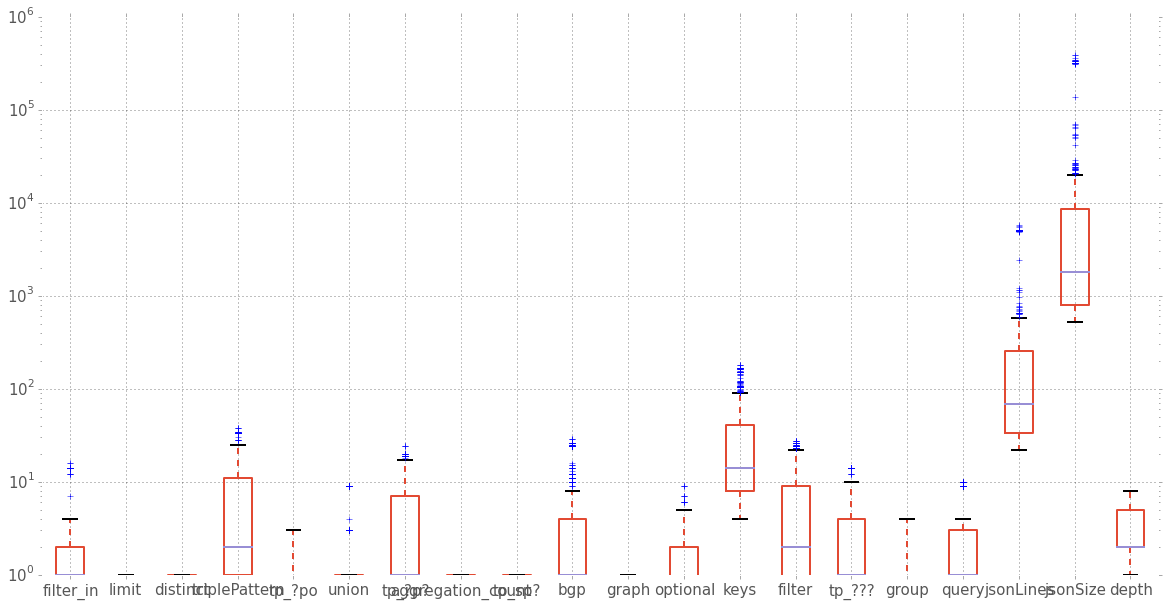

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))




df_query_features[df_query_features.columns[1:]].plot(kind='box', logy=True, ax=ax)

fig.savefig('QueryFeatureBoxplots.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('QueryFeatureBoxplots.eps', format='eps', bbox_inches='tight', dpi=1200)


In [24]:
df_query_features.columns

Index(['order', 'filter_in', 'limit', 'distinct', 'triplePattern', 'tp_?po',
       'union', 'tp_?p?', 'aggregation_count', 'tp_sp?', 'bgp', 'graph',
       'optional', 'keys', 'filter', 'tp_???', 'group', 'query', 'jsonLines',
       'jsonSize', 'depth'],
      dtype='object')

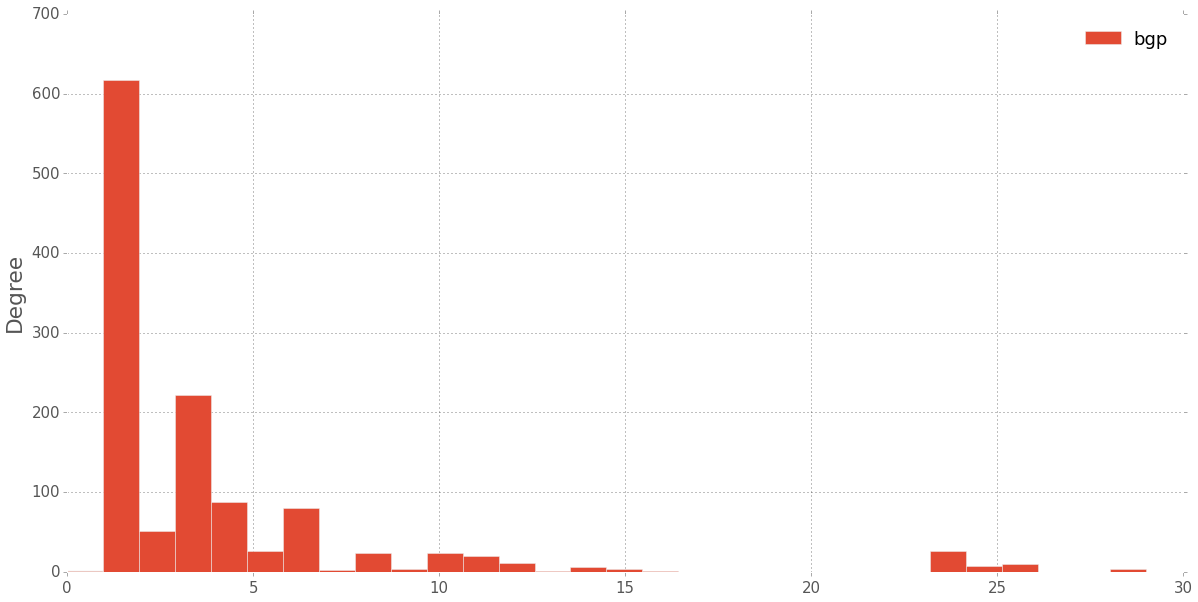

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

df_query_features[['bgp']].plot(kind='hist', bins=30, ax=ax)

fig.savefig('QueryBGPDistribution.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('QueryBGPDistribution.eps', format='eps', bbox_inches='tight', dpi=1200)


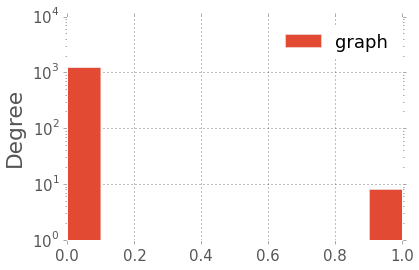

In [26]:
df_query_features[['graph']].plot(kind='hist', logy=True)

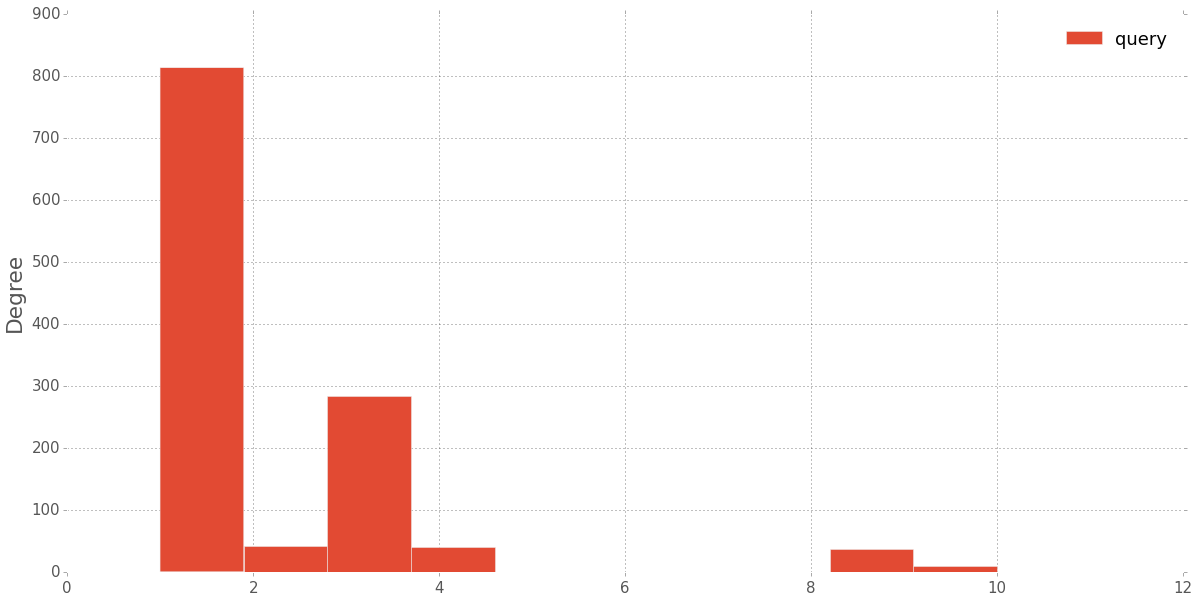

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))

df_query_features[['query']].plot(kind='hist', logy=False, ax=ax)

fig.savefig('AmountOfSubqueries.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('AmountOfSubqueries.eps', format='eps', bbox_inches='tight', dpi=1200)



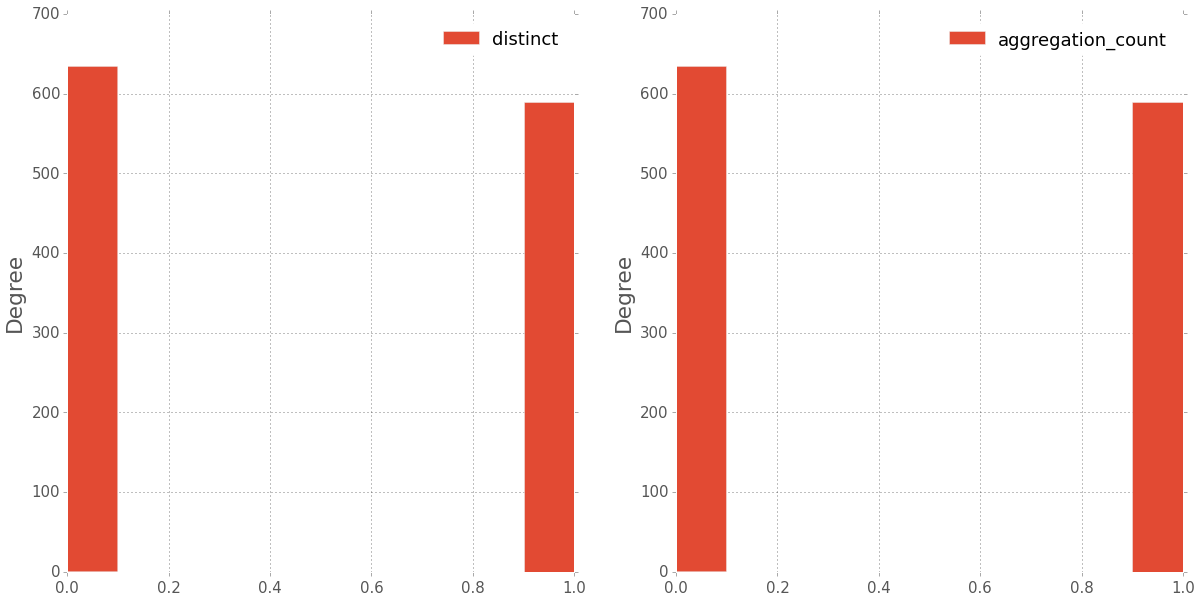

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))

df_query_features[['distinct']].plot(kind='hist', logy=False, ax=ax[0])
df_query_features[['aggregation_count']].plot(kind='hist', logy=False, ax=ax[1])

fig.savefig('CountDistinct.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('CountDistinct.eps', format='eps', bbox_inches='tight', dpi=1200)

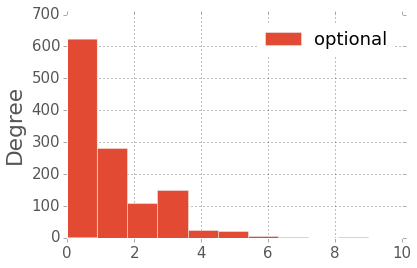

In [29]:
df_query_features[['optional']].plot(kind='hist', logy=False)

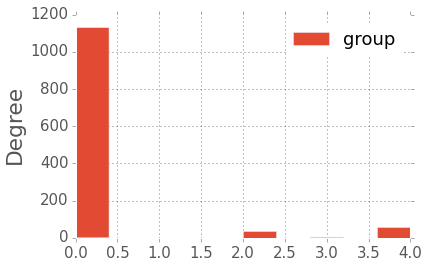

In [30]:
df_query_features[['group']].plot(kind='hist', logy=False)

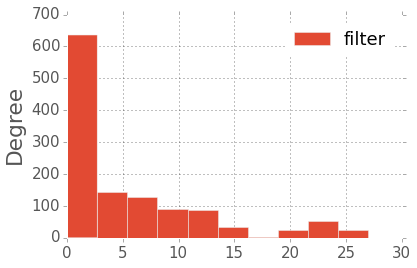

In [31]:
df_query_features[['filter']].plot(kind='hist', logy=False)

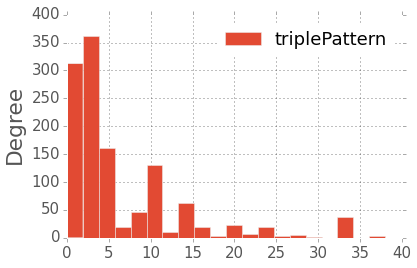

In [32]:
df_query_features[['triplePattern']].plot(kind='hist', logy=False, bins=20)

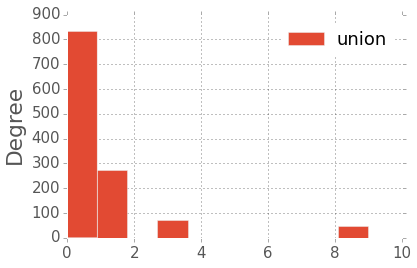

In [33]:
df_query_features[['union']].plot(kind='hist', logy=False)

In [34]:
df_query_features.columns

Index(['order', 'filter_in', 'limit', 'distinct', 'triplePattern', 'tp_?po',
       'union', 'tp_?p?', 'aggregation_count', 'tp_sp?', 'bgp', 'graph',
       'optional', 'keys', 'filter', 'tp_???', 'group', 'query', 'jsonLines',
       'jsonSize', 'depth'],
      dtype='object')

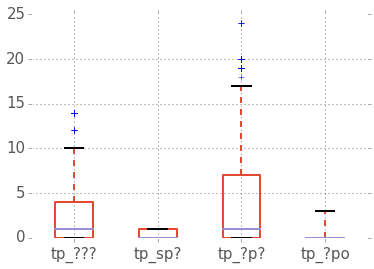

In [35]:
df_query_features[["tp_???", "tp_sp?", "tp_?p?", "tp_?po"]].plot(kind='box', logy=False)

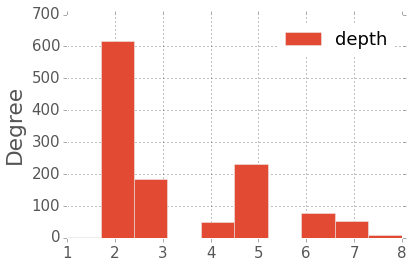

In [36]:
df_query_features[['depth']].plot(kind='hist', logy=False)

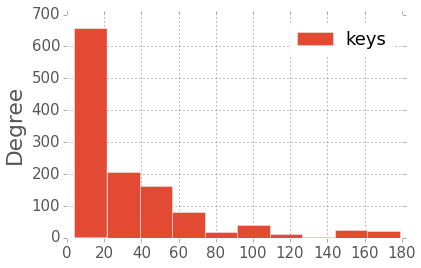

In [37]:
df_query_features[['keys']].plot(kind='hist', logy=False)

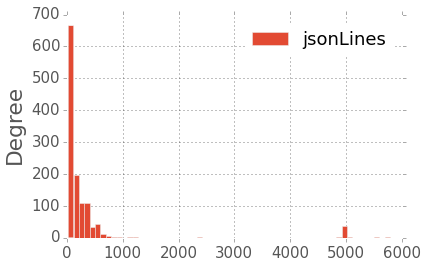

In [38]:
df_query_features[['jsonLines']].plot(kind='hist', logy=False, bins=60)

###  distribution extra features

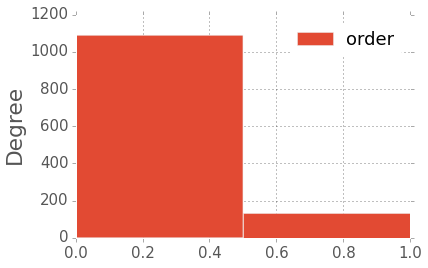

In [39]:
df_query_features[['order']].plot(kind='hist', logy=False, bins=2)

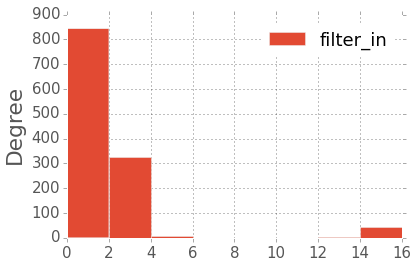

In [40]:
df_query_features[['filter_in']].plot(kind='hist', logy=False, bins=8)

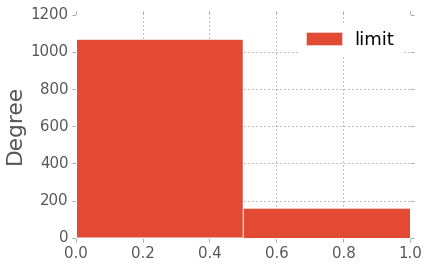

In [41]:
df_query_features[['limit']].plot(kind='hist', logy=False, bins=2)

## Figs for SWAT4LS


In [42]:
df_query_features.columns

Index(['order', 'filter_in', 'limit', 'distinct', 'triplePattern', 'tp_?po',
       'union', 'tp_?p?', 'aggregation_count', 'tp_sp?', 'bgp', 'graph',
       'optional', 'keys', 'filter', 'tp_???', 'group', 'query', 'jsonLines',
       'jsonSize', 'depth'],
      dtype='object')

In [43]:
df_keywords = df_query_features[["optional", "distinct", "aggregation_count", "graph", "filter", "union", "group", "filter_in", "order"]]

In [44]:
df_keywords.columns = ["OPTIONAL", "DISTINCT", "COUNT", "GRAPH", "FILTER", "UNION", "GROUP", "FILTER_IN", "ORDER"]

In [45]:
df_keywords['FILTER_='] = df_keywords['FILTER'] - df_keywords['FILTER_IN']

/home/ddewitte/anaconda3/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


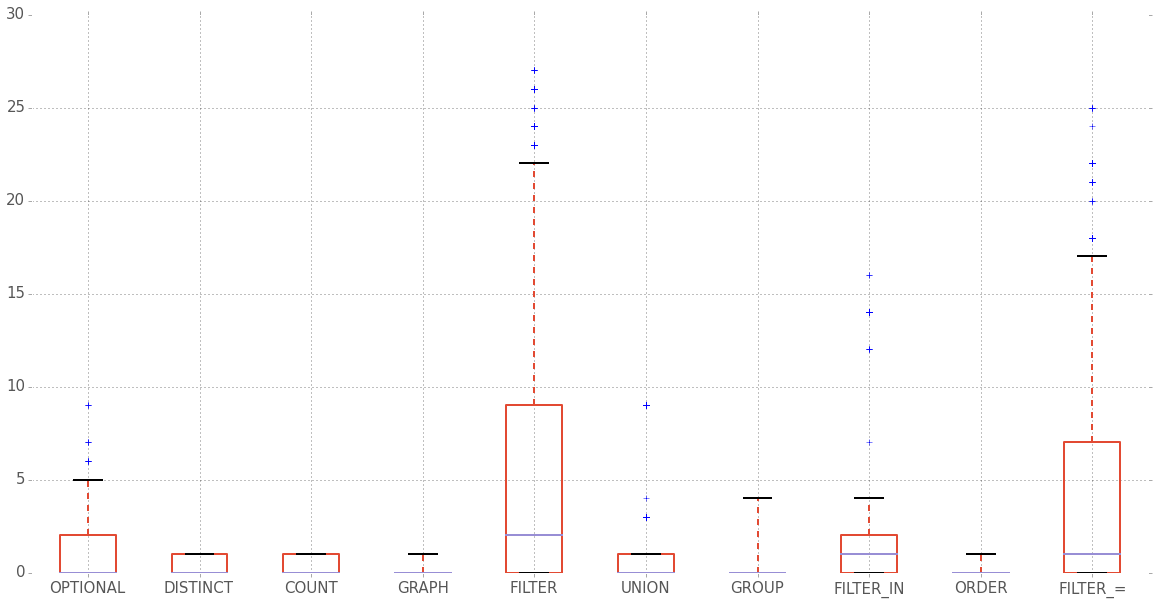

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
df_keywords.plot(kind='box', logy=False, ax=ax)

fig.savefig('QueryKeywordDistribution1.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('QueryKeywordDistribution1.eps', format='eps', bbox_inches='tight', dpi=1200)




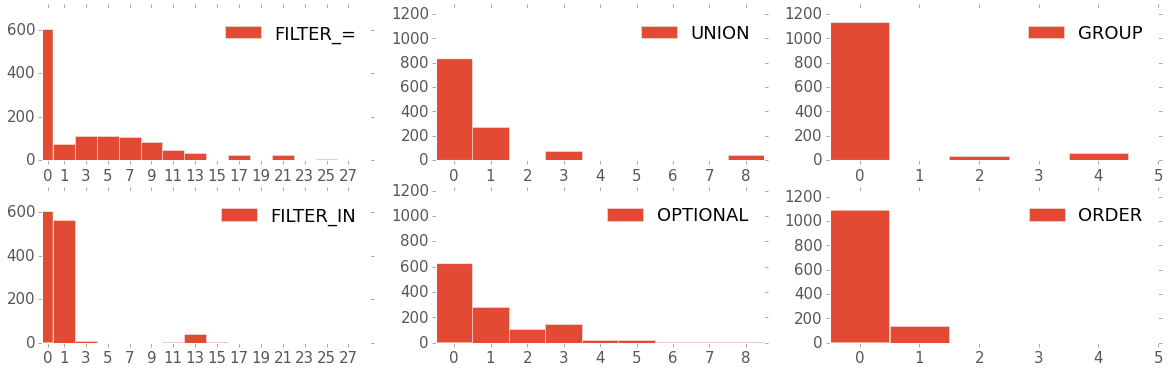

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(20,6))

#ticks2 = [">=1", ">=10", ">=1e2", ">=1e3", ">=1e4", ">=1e5", ">=1e6", ">=1e7", ">=1e8"]
#ax[1].set_xticklabels(ticks2)
#ax[1].set_xticks(np.arange(0,9) + 0.5)


#df_keywords[['COUNT']].plot(kind='hist',    bins=np.arange(0,3,1),  ax=ax[0][1], grid=True, ylim=[0,1250])
#ax[0][1].set_xticks(np.arange(0,2,1) + 0.5)
#ax[0][1].set_xticklabels(np.arange(0,2,1))




df_keywords[['OPTIONAL']].plot(kind='hist', bins=np.arange(0,10,1), ax=ax[1][1], grid=False, ylim=[0,700])
ax[1][1].set_xticks(np.arange(0,9,1) + 0.5)
ax[1][1].set_xticklabels(np.arange(0,9,1))

df_keywords[['UNION']].plot(kind='hist',    bins=np.arange(0,10,1), ax=ax[0][1], grid=False, ylim=[0,1250])
ax[0][1].set_xticks(np.arange(0,9,1) + 0.5)
ax[0][1].set_xticklabels(np.arange(0,9,1))

df_keywords[['FILTER_=']].plot(kind='hist',  bins=[0,1,3,5,7,9,11,13,15,17,19,21,23,25,27], ax=ax[0][0], grid=False, ylim=[0,700])
ax[0][0].set_xticks(np.array([-0.5,1,3,5,7,9,11,13,15,17,19,21,23,25,27]) + 1)
ax[0][0].set_xticklabels(np.array([0,1,3,5,7,9,11,13,15,17,19,21,23,25,27]))

df_keywords[['FILTER_IN']].plot(kind='hist', bins=[0,1,3,5,7,9,11,13,15,17,19,21,23,25,27],  ax=ax[1][0], grid=False, ylim=[0,700])
ax[1][0].set_xticks(np.array([-0.5,1,3,5,7,9,11,13,15,17,19,21,23,25,27]) + 1)
ax[1][0].set_xticklabels(np.array([0,1,3,5,7,9,11,13,15,17,19,21,23,25,27]))



df_keywords[['GROUP']].plot(kind='hist',    bins=np.arange(0,6,1),  ax=ax[0][2], grid=False, ylim=[0,1250])
ax[0][2].set_xticks(np.arange(0,6,1) + 0.5)
ax[0][2].set_xticklabels(np.arange(0,6,1))

df_keywords[['ORDER']].plot(kind='hist', stacked=False, bins=np.arange(0,6,1),  ax=ax[1][2],\
                                    grid=False, ylim=[0,1250])
ax[1][2].set_xticks(np.arange(0,6,1) + 0.5)
ax[1][2].set_xticklabels(np.arange(0,6,1))

#ax[0][0].set_xticks(np.arange(0,30,3) + 0.5)
#ax[0][0].set_xticklabels(np.arange(0,30,3))

#df_keywords[['GRAPH']].plot(kind='hist',    bins=np.arange(0,3,1),  ax=ax[1][1], grid=True, ylim=[0,1250])
#ax[1][1].set_xticks(np.arange(0,2,1) + 0.5)
#ax[1][1].set_xticklabels(np.arange(0,2,1))



ax[0][0].set_ylabel("")
ax[0][1].set_ylabel("")
ax[0][2].set_ylabel("")
ax[1][0].set_ylabel("")
ax[1][1].set_ylabel("")
ax[1][2].set_ylabel("")


ax[0][0].set_yticks(np.arange(0,800,200))
ax[1][0].set_yticks(np.arange(0,800,200))

ax[0][1].set_yticks(np.arange(0,1400,200))
ax[0][2].set_yticks(np.arange(0,1400,200))
ax[1][1].set_yticks(np.arange(0,1400,200))
ax[1][2].set_yticks(np.arange(0,1400,200))


fig.savefig('QueryKeywordDistribution2.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('QueryKeywordDistribution2.eps', format='eps', bbox_inches='tight', dpi=1200)

In [67]:
df_keywords.groupby(['ORDER']).count()

,OPTIONAL,DISTINCT,COUNT,GRAPH,FILTER,UNION,GROUP,FILTER_IN,FILTER_=
ORDER,,,,,,,,,
0,1089,1089,1089,1089,1089,1089,1089,1089,1089
1,134,134,134,134,134,134,134,134,134


In [49]:
df_keywords.groupby(['DISTINCT']).count()

,OPTIONAL,COUNT,GRAPH,FILTER,UNION,GROUP,FILTER_IN,ORDER,FILTER_=
DISTINCT,,,,,,,,,
0,634,634,634,634,634,634,634,634,634
1,589,589,589,589,589,589,589,589,589


In [65]:
df_keywords.groupby(['OPTIONAL']).count()

,DISTINCT,COUNT,GRAPH,FILTER,UNION,GROUP,FILTER_IN,ORDER,FILTER_=
OPTIONAL,,,,,,,,,
0,623,623,623,623,623,623,623,623,623
1,282,282,282,282,282,282,282,282,282
2,110,110,110,110,110,110,110,110,110
3,151,151,151,151,151,151,151,151,151
4,24,24,24,24,24,24,24,24,24
5,22,22,22,22,22,22,22,22,22
6,5,5,5,5,5,5,5,5,5
7,3,3,3,3,3,3,3,3,3
9,3,3,3,3,3,3,3,3,3


In [62]:
df_query_features.groupby(['filter_in']).count()

,order,limit,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,bgp,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
filter_in,,,,,,,,,,,,,,,,,,,,
0,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603,603
1,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240,240
2,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326,326
4,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
14,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
16,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [52]:
df_query_features.groupby(['limit']).count()

,order,filter_in,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,bgp,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
limit,,,,,,,,,,,,,,,,,,,,
0,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065,1065
1,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158


In [53]:
df_query_features.groupby(['order']).count()

,filter_in,limit,distinct,triplePattern,tp_?po,union,tp_?p?,aggregation_count,tp_sp?,bgp,graph,optional,keys,filter,tp_???,group,query,jsonLines,jsonSize,depth
order,,,,,,,,,,,,,,,,,,,,
0,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089,1089
1,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134,134


In [54]:
df_query_complexity = df_query_features[["query", "bgp", "triplePattern", "keys", "jsonLines", "depth", ]]

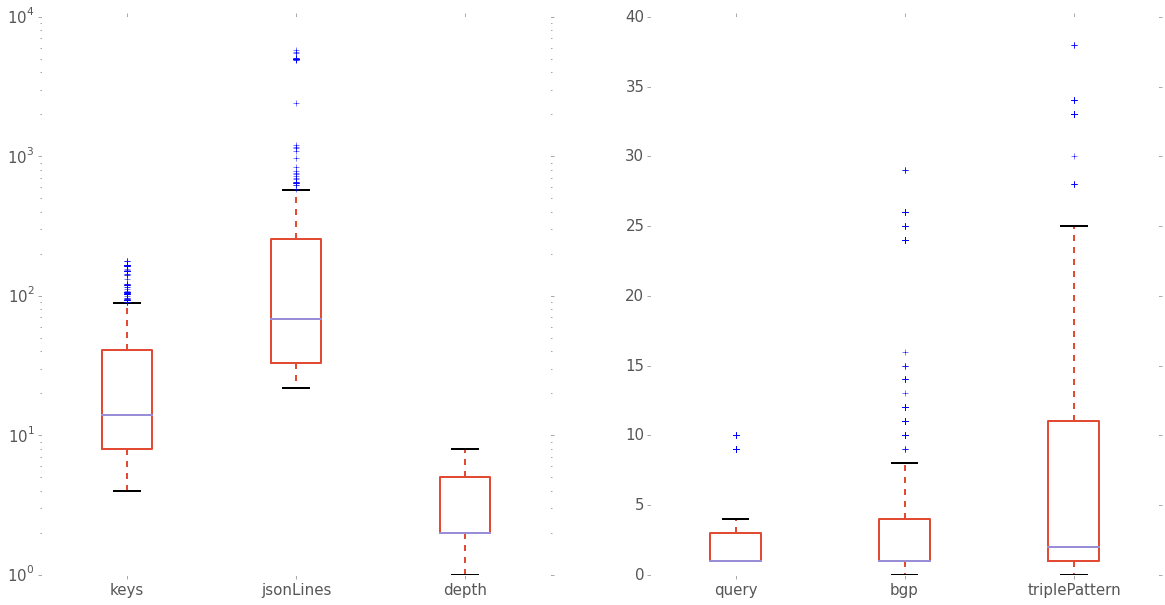

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))


df_query_complexity[["keys", "jsonLines", "depth"]].plot(kind='box', logy=True, grid=False, ax=ax[0])
df_query_complexity[["query", "bgp", "triplePattern"]].plot(kind='box', logy=False, grid=False, ax=ax[1])

fig.savefig('QueryComplexity.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('QueryComplexity.eps', format='eps', bbox_inches='tight', dpi=1200)

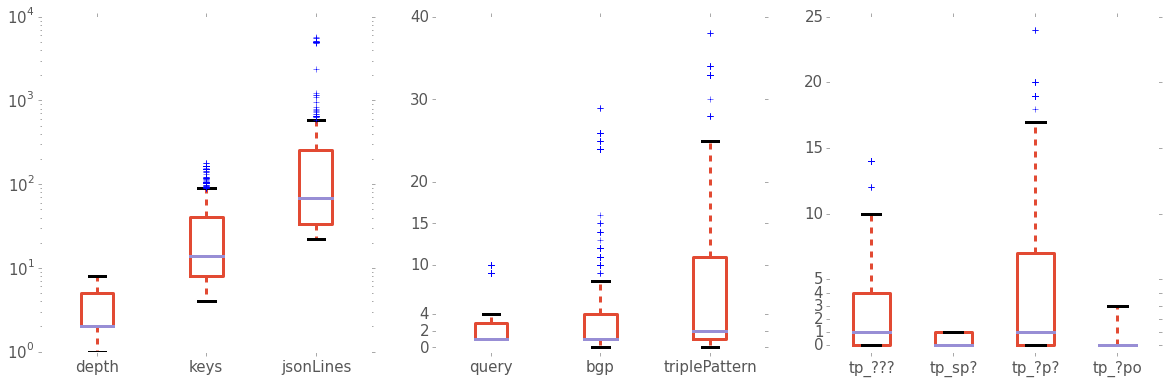

In [56]:
mpl.rcParams['lines.linewidth'] = '3.0'        # line width in points

fig, ax = plt.subplots(1, 3, figsize=(20,6))
df_query_complexity[["depth","keys", "jsonLines"]].plot(kind='box', logy=True, grid=False, ax=ax[0], ylim=[0,1e4])

df_query_complexity[["query", "bgp", "triplePattern"]].plot(kind='box', logy=False, grid=False, ax=ax[1], ylim=[-0.5,40])

df_tp_distribution = df_query_features[["tp_???", "tp_sp?", "tp_?p?", "tp_?po"]]
df_tp_distribution.plot(kind='box', ax=ax[2], grid=False, ylim=[-0.5,25])

#ax[0].minorticks_on
#ax[0].grid(True, which='both')

ax[1].set_yticks(np.array([0,2,4,10,15,20,30,40]))
ax[2].set_yticks(np.array([0,1,2,3,4,5,10,15,20,25]))

fig.savefig('PatternComplexity.svg', format='svg', bbox_inches='tight', dpi=1200)
fig.savefig('PatternComplexity.eps', format='eps', bbox_inches='tight', dpi=1200)